In [1]:
import os  
import numpy as np
import struct
import matplotlib.pyplot as plt
import gc
import random
from tensorflow import keras

In [127]:
with open("C:\\Users\\Administrator\\source\\data\\dataset.bin", "rb") as file0:
    data1 = file0.read(4)
    NM1 = struct.unpack("i", data1)[0]
    sig1 = np.zeros((NM1,200),dtype = np.float32)
    an1 = np.zeros((NM1,4),dtype = np.float32)
    for i in range(NM1):
        for k in range(4):
            data1 = file0.read(4)
            an1[i,k] = struct.unpack("f", data1)[0]
        for k in range(200):
            data1 = file0.read(4)
            sig1[i,k] = struct.unpack("f", data1)[0]  
    # data1 = file0.read(len('end\0'))
    # end = struct.unpack("4s", data1)[0]  

In [128]:
with open("C:\\Users\\Administrator\\source\\data\\dataset0.0.bin", "rb") as file0:
    data1 = file0.read(4)
    NM1 = struct.unpack("i", data1)[0]
    sig2 = np.zeros((NM1,200),dtype = np.float32)
    an2 = np.zeros((NM1,4),dtype = np.float32)
    for i in range(NM1):
        for k in range(4):
            data1 = file0.read(4)
            an2[i,k] = struct.unpack("f", data1)[0]
        for k in range(200):
            data1 = file0.read(4)
            sig2[i,k] = struct.unpack("f", data1)[0]  
    # data1 = file0.read(len('end\0'))
    # end = struct.unpack("4s", data1)[0]  

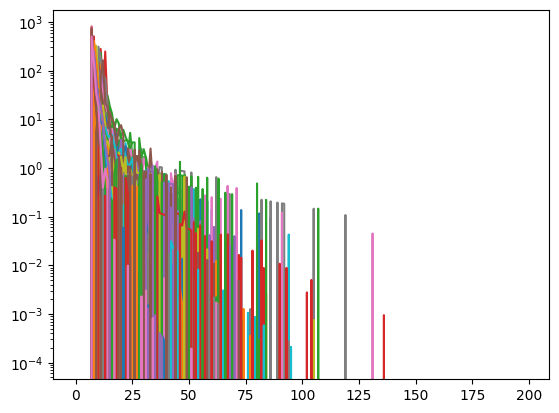

167
[1.0030099e-02 3.1123728e+01 7.9206685e+03 8.5000002e-01]


In [129]:
plt.axes(yscale = "log") 
for n in range(NM1):
    plt.plot(sig2[n])
plt.show()
print(NM1)
print(an1[-1])

In [130]:

def labeling(y,N):
    ##############
    a,b = y.shape
    min0 = np.min(y,0)
    max0 = np.max(y,0)
    step = (max0-min0)/N
    y2 = np.zeros((a,b,N))
    for i in range(a):
        for j in range(b):
            if(step[j]!=0):
                idx = (y[i,j]-min0[j])/step[j]-1
                y2[i,j,int(idx)] = 1
            else:
                y2[i,j,0] = 1

    return y2    
  

In [131]:
print(sig1.shape)
print(an1.shape)
print(sig2.shape)
print(an2.shape)
num_labels = 10
x_train = sig1
y_train = an1
x_test = sig2
y_test = an2
x_train = np.log((x_train+1e-10)/1000)+30
x_test = np.log((x_test+1e-10)/1000)+30
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
y_train = labeling(y_train,num_labels)[:,0,:]
y_test = labeling(y_test,num_labels)[:,0,:]
print('x_train.shape = '+str(x_train.shape)) 
print('y_train.shape = '+str(y_train.shape)) 

(266, 200)
(266, 4)
(167, 200)
(167, 4)
x_train.shape = (266, 200, 1)
y_train.shape = (266, 10)


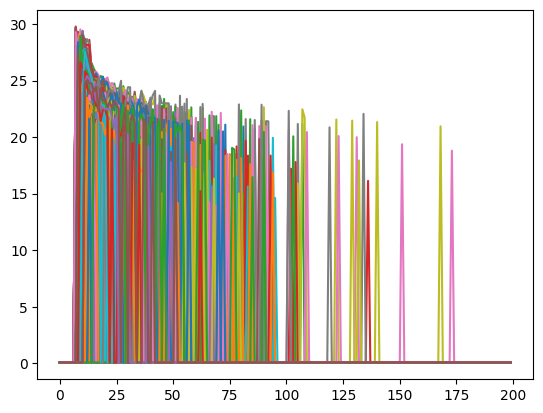

In [132]:
for n in range(x_train.shape[0]):
    plt.plot(x_train[n])
plt.show()


In [133]:
num_classes = y_train.shape[1]

In [134]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)
    
    # range_ = keras.layers.Dense(1, input_shape=(1,), activation='relu')
    # merged = keras.layers.Concatenate()([gap, range_])
    # # merged.add(Dense(n_classes, activation='softmax'))

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [135]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
7/7 [==============================] - 1s 66ms/step - loss: 2.2556 - categorical_accuracy: 0.1368 - val_loss: 2.2464 - val_categorical_accuracy: 0.0000e+00
Epoch 2/500
7/7 [==============================] - 0s 15ms/step - loss: 2.0725 - categorical_accuracy: 0.2689 - val_loss: 2.2077 - val_categorical_accuracy: 0.1852
Epoch 3/500
7/7 [==============================] - 0s 16ms/step - loss: 1.9769 - categorical_accuracy: 0.3255 - val_loss: 2.1727 - val_categorical_accuracy: 0.1852
Epoch 4/500
7/7 [==============================] - 0s 15ms/step - loss: 1.9065 - categorical_accuracy: 0.3255 - val_loss: 2.1567 - val_categorical_accuracy: 0.1852
Epoch 5/500
7/7 [==============================] - 0s 15ms/step - loss: 1.8557 - categorical_accuracy: 0.3491 - val_loss: 2.0906 - val_categorical_accuracy: 0.1852
Epoch 6/500
7/7 [==============================] - 0s 15ms/step - loss: 1.8224 - categorical_accuracy: 0.3302 - val_loss: 2.0272 - val_categorical_accuracy: 0.1852
Epoch 7/500


In [136]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

6/6 [==============================] - 0s 55ms/step - loss: 1.8199 - categorical_accuracy: 0.3533
Test accuracy 0.35329341888427734
Test loss 1.819878339767456


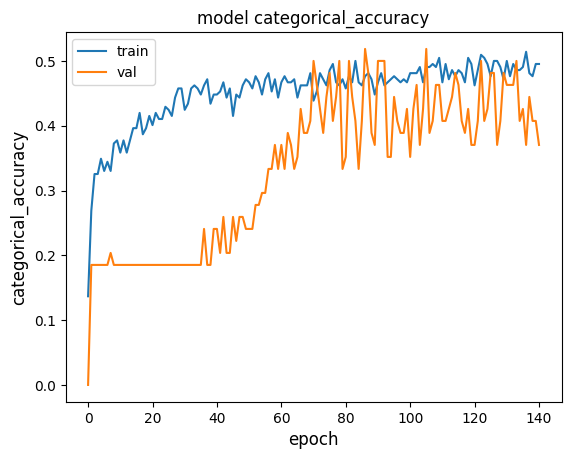

In [137]:
metric = "categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [ ]:
# 你可以用pca或者一些降维方法把特征搞一下